In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
# Supprimer les warnings pour un affichage plus propre
warnings.filterwarnings('ignore')

# Configuration de style pour les graphiques
plt.style.use('default')
sns.set_palette("husl")


In [2]:
def load_bitcoin_data(file_path):
    """
    Charge les données Bitcoin depuis le fichier CSV
    """
    try:
        # Charger les données
        df = pd.read_csv(file_path)
        
        # Convertir la colonne de temps en datetime
        df['Open time'] = pd.to_datetime(df['Open time'])
        
        # Nettoyer les noms de colonnes (enlever les espaces)
        df.columns = df.columns.str.strip()
        
        # Définir l'index comme datetime
        df.set_index('Open time', inplace=True)
        
        print(f"Données chargées avec succès!")
        print(f"Période: {df.index.min()} à {df.index.max()}")
        print(f"Nombre d'enregistrements: {len(df):,}")
        
        return df
        
    except Exception as e:
        print(f"Erreur lors du chargement des données: {e}")
        return None

In [4]:
def basic_statistics(df):
    """
    Affiche les statistiques de base des données Bitcoin
    """
    print("\n" + "="*50)
    print("STATISTIQUES DESCRIPTIVES")
    print("="*50)
    
    # Statistiques pour les prix principaux
    price_cols = ['Open', 'High', 'Low', 'Close']
    print(df[price_cols].describe())
    
    print(f"\n📈 Prix le plus haut: ${df['High'].max():,.2f}")
    print(f"📉 Prix le plus bas: ${df['Low'].min():,.2f}")
    print(f"💰 Prix de clôture actuel: ${df['Close'].iloc[-1]:,.2f}")
    
    # Calcul de la volatilité quotidienne moyenne
    df['Daily_Range'] = ((df['High'] - df['Low']) / df['Open']) * 100
    print(f"🎯 Volatilité moyenne quotidienne: {df['Daily_Range'].mean():.2f}%")

In [3]:

print("🚀 ANALYSE DES DONNÉES BITCOIN")
print("="*50)

# Charger les données
file_path_15m = "btc_15m_data_2018_to_2025.csv"
file_path_1h = "btc_1h_data_2018_to_2025.csv"
file_path_4h = "btc_4h_data_2018_to_2025.csv"
file_path_1d = "btc_1d_data_2018_to_2025.csv"

df_15m = load_bitcoin_data(file_path_15m)
df_1h = load_bitcoin_data(file_path_1h)
df_4h = load_bitcoin_data(file_path_4h)
df_1d = load_bitcoin_data(file_path_1d)

# Afficher les statistiques de base pour les données 1 jour
print("\n🔍 STATISTIQUES DES DONNÉES QUOTIDIENNES")
basic_statistics(df_1d)

🚀 ANALYSE DES DONNÉES BITCOIN
Données chargées avec succès!
Période: 2018-01-01 00:00:00 à 2025-12-10 23:15:00
Nombre d'enregistrements: 277,963
Données chargées avec succès!
Période: 2018-01-01 00:00:00 à 2025-12-23 21:00:00
Nombre d'enregistrements: 69,815
Données chargées avec succès!
Période: 2018-01-01 00:00:00 à 2025-12-23 12:00:00
Nombre d'enregistrements: 17,469
Données chargées avec succès!
Période: 2018-01-01 00:00:00+00:00 à 2025-12-24 00:00:00+00:00
Nombre d'enregistrements: 2,915

🔍 STATISTIQUES DES DONNÉES QUOTIDIENNES


NameError: name 'basic_statistics' is not defined

## Debut de l'implémentation LSTM - Dataset 15min

On va tenter de prédire la pente du marché, une direction future :
y = -1 → baisse
y =  0 → neutre
y = +1 → hausse

Quel horizon de prédiction ? 
On va tenter de débuter par H = 4, soit prédire la direction pour l'heure qui suit

On implémentera cette formule : r(t,h) = prix(t+h)-prix(t) / prix(t)
Cette formule nous donnera donc une premier pourcentage de baisse/hausse. Ajouté à un seuil défini pour plus de robustesse, on pourra avoir la premiere idée de notre pente, et donc ajouter notre label pour les données d'entrainement
si r > +ε → +1
si r < -ε → -1
sinon → 0

In [4]:
def add_pente(close_price, horizon:int, epsilon:float):

    labels = []
    
    # Convert to numpy array to use integer indexing
    prices = close_price.values if hasattr(close_price, 'values') else close_price
    
    for t in range(len(prices) - horizon):
        future_return = (prices[t+horizon] - prices[t]) / prices[t]
        if future_return > epsilon:
            labels.append(1)
        elif future_return < -epsilon:
            labels.append(-1)
        else:
            labels.append(0)
    return labels


In [5]:
print(df_15m.head())

                         Open      High       Low     Close      Volume  \
Open time                                                                 
2018-01-01 00:00:00  13715.65  13715.65  13400.01  13556.15  123.616013   
2018-01-01 00:15:00  13533.75  13550.87  13402.00  13521.12   98.136430   
2018-01-01 00:30:00  13500.00  13545.37  13450.00  13470.41   79.904037   
2018-01-01 00:45:00  13494.65  13690.87  13450.00  13529.01  141.699719   
2018-01-01 01:00:00  13528.99  13571.74  13402.28  13445.63   72.537533   

                                      Close time  Quote asset volume  \
Open time                                                              
2018-01-01 00:00:00  2018-01-01 00:14:59.999000         1.675545e+06   
2018-01-01 00:15:00  2018-01-01 00:29:59.999000         1.321757e+06   
2018-01-01 00:30:00  2018-01-01 00:44:59.999000         1.078825e+06   
2018-01-01 00:45:00  2018-01-01 00:59:59.999000         1.917783e+06   
2018-01-01 01:00:00  2018-01-01 01:14:59.9

In [6]:
df_15m_close_prices = df_15m[['Close', 'Number of trades', 'Volume']].copy()

labels = add_pente(df_15m['Close'], 4, 0.002) #On essaye avec un epsilon de 0.2% pour les données 15m

df_15m_close_prices['Pente'] = labels + [np.nan] * 4 #On ajoute la pente

df_15m_close_prices['Return'] = df_15m_close_prices['Close'].pct_change() 

df_15m_close_prices['High Low Range'] = df_15m['High']-df_15m['Low']

df_15m_close_prices['Volume ratio'] = df_15m_close_prices['Volume'] / df_15m_close_prices['Volume'].rolling(window=32).mean()

df_15m_close_prices['Volatilty'] = df_15m_close_prices['Return'].rolling(window=32).std()

df_15m_close_prices.dropna(inplace=True)

print(df_15m_close_prices.head())

                        Close  Number of trades      Volume  Pente    Return  \
Open time                                                                      
2018-01-01 08:00:00  13656.23               919   58.542067   -1.0  0.006329   
2018-01-01 08:15:00  13632.89               869   58.900513   -1.0 -0.001709   
2018-01-01 08:30:00  13434.71              1204  104.766871    1.0 -0.014537   
2018-01-01 08:45:00  13499.99               741   49.604102    1.0  0.004859   
2018-01-01 09:00:00  13589.83               825   55.827255   -1.0  0.006655   

                     High Low Range  Volume ratio  Volatilty  
Open time                                                     
2018-01-01 08:00:00          145.00      0.643022   0.007122  
2018-01-01 08:15:00          124.97      0.655791   0.007112  
2018-01-01 08:30:00          249.96      1.156458   0.007551  
2018-01-01 08:45:00           93.93      0.565515   0.007561  
2018-01-01 09:00:00          140.87      0.640274   0.007566 

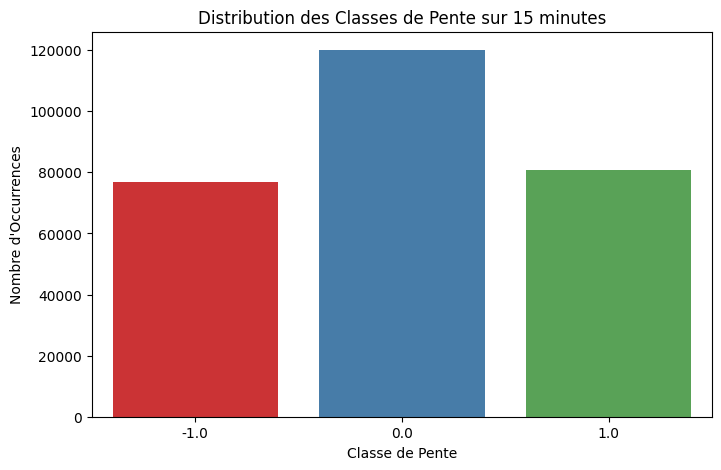

In [9]:
#Visualiser la distribution des classes
plt.figure(figsize=(8, 5))
sns.countplot(x='Pente', data=df_15m_close_prices, palette='Set1')
plt.title('Distribution des Classes de Pente sur 15 minutes')
plt.xlabel('Classe de Pente')
plt.ylabel('Nombre d\'Occurrences')
plt.show()
 

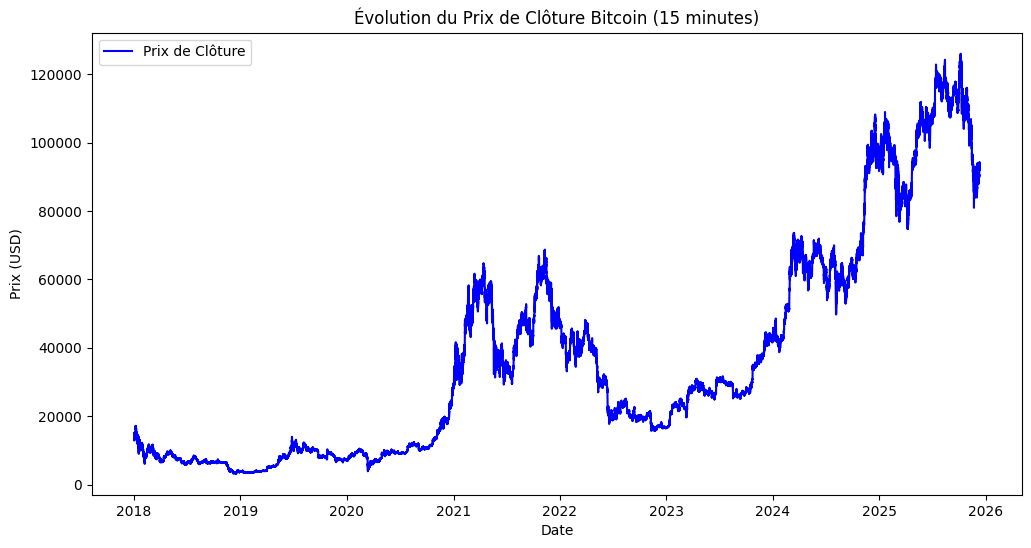

In [10]:
#Visualiser les prix

plt.figure(figsize=(12, 6))
plt.plot(df_15m_close_prices.index, df_15m_close_prices['Close'], label='Prix de Clôture', color='blue')
plt.title('Évolution du Prix de Clôture Bitcoin (15 minutes)')
plt.xlabel('Date')
plt.ylabel('Prix (USD)')
plt.legend()
plt.show()

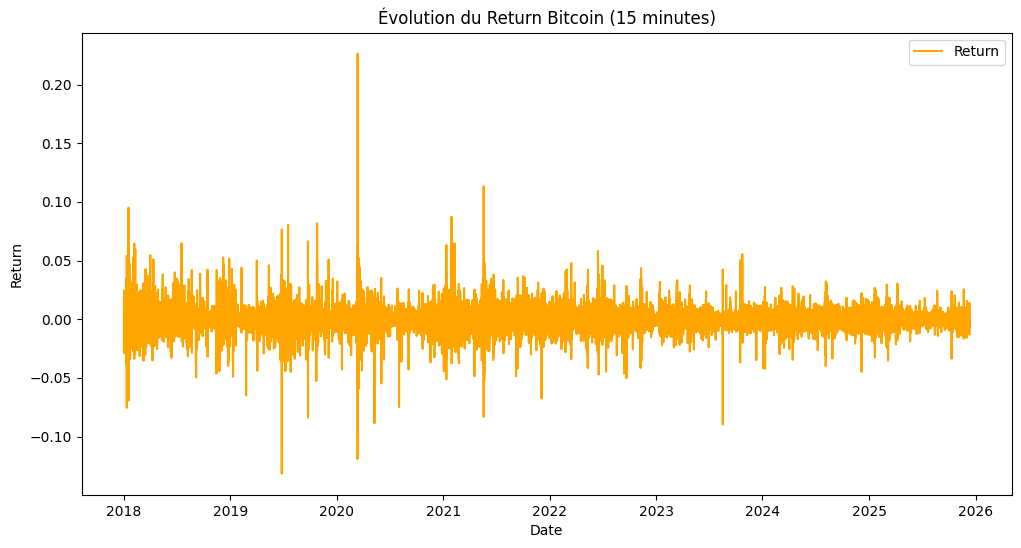

In [11]:
# Visualiser le Return
plt.figure(figsize=(12, 6))
plt.plot(df_15m_close_prices.index, df_15m_close_prices['Return'], label='Return', color='orange')
plt.title('Évolution du Return Bitcoin (15 minutes)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

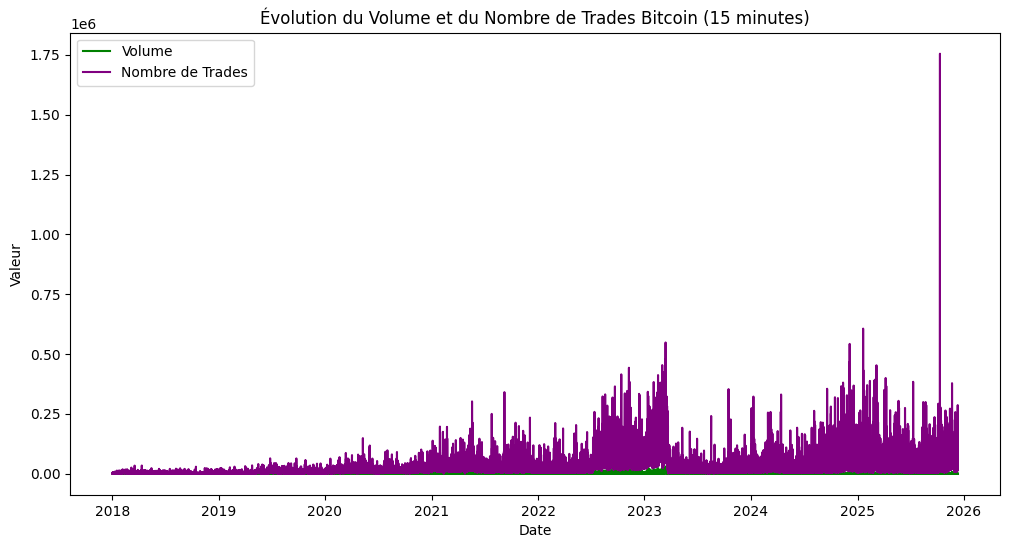

In [12]:
#Visualiser le volume et nb de trades
plt.figure(figsize=(12, 6))
plt.plot(df_15m_close_prices.index, df_15m_close_prices['Volume'], label='Volume', color='green')
plt.plot(df_15m_close_prices.index, df_15m_close_prices['Number of trades'], label='Nombre de Trades', color='purple')
plt.title('Évolution du Volume et du Nombre de Trades Bitcoin (15 minutes)')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.show()

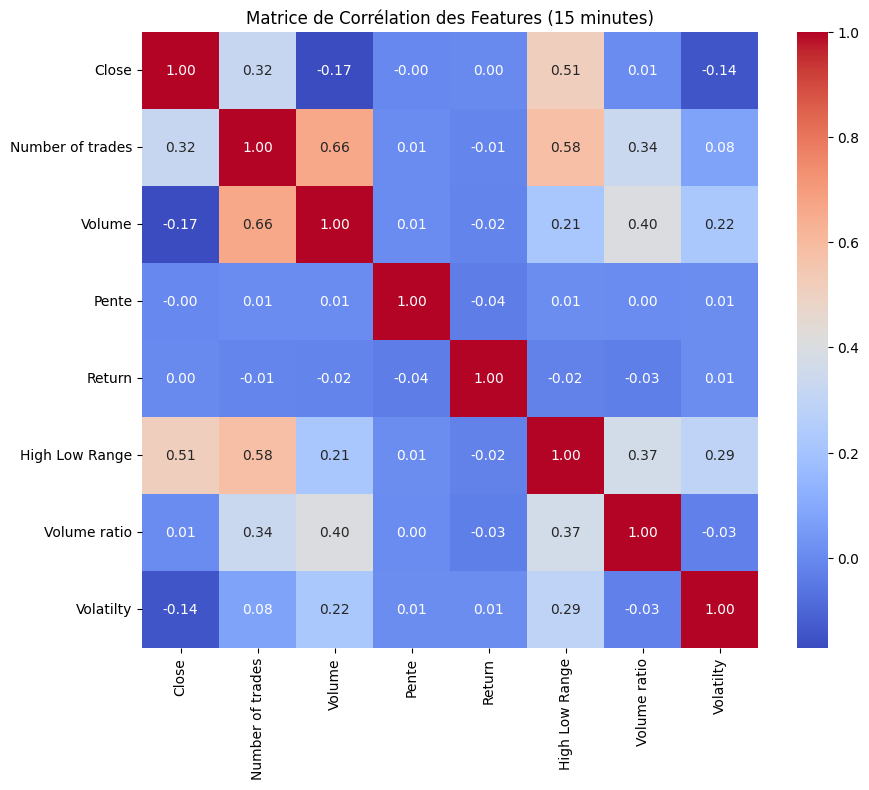

In [13]:
#Matrice de corrélation entre features
plt.figure(figsize=(10, 8))
corr = df_15m_close_prices.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matrice de Corrélation des Features (15 minutes)')
plt.show()


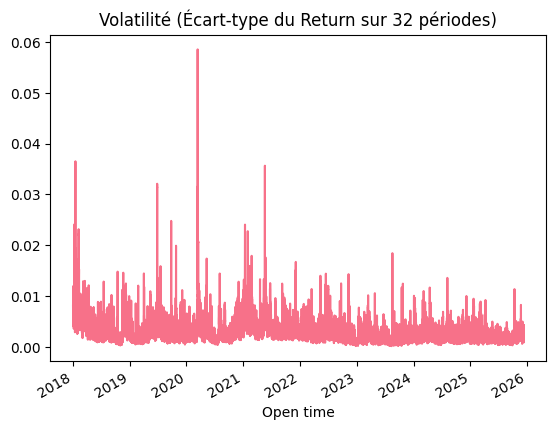

In [14]:
df_15m_close_prices['Return'].rolling(window=32).std().plot(title='Volatilité (Écart-type du Return sur 32 périodes)')
plt.show()

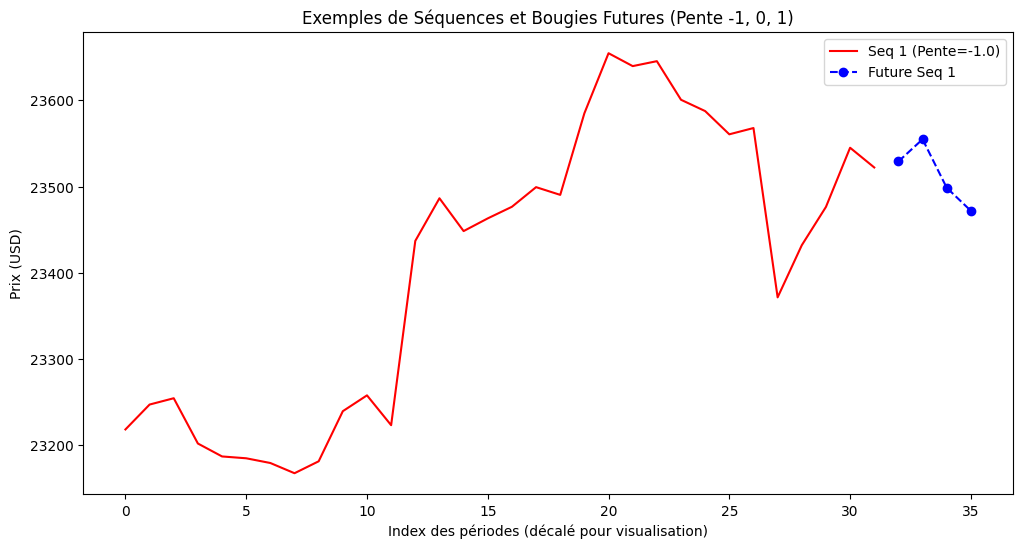

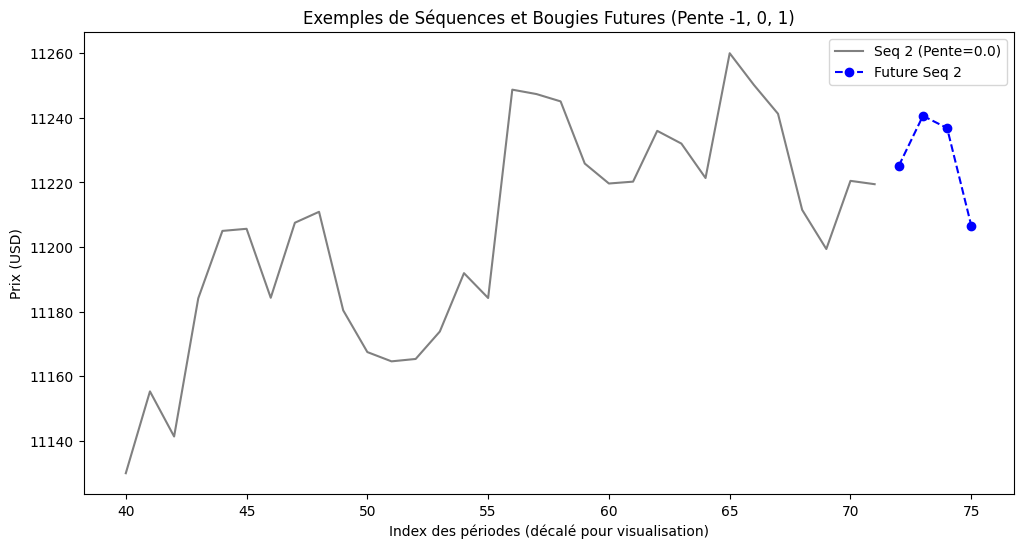

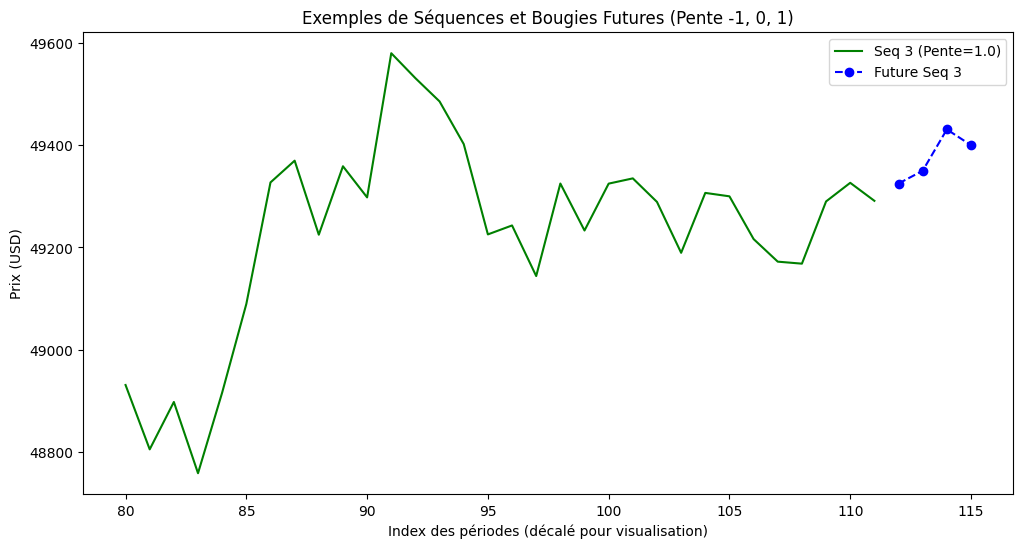

In [15]:
# Fonction pour récupérer un indice aléatoire pour une pente spécifique
def random_index_for_pente(df, pente_val):
    indices = np.where(df['Pente'].values == pente_val)[0]
    # Filtrer les indices qui permettent de prendre 32 bougies + 4 futures
    valid_indices = [idx for idx in indices if idx >= 31 and idx + 4 < len(df)]
    if len(valid_indices) == 0:
        return None
    # Choisir un indice aléatoire parmi les valides
    return np.random.choice(valid_indices)

# Récupérer les indices pour chaque pente
idx_neg = random_index_for_pente(df_15m_close_prices, -1)
idx_zero = random_index_for_pente(df_15m_close_prices, 0)
idx_pos = random_index_for_pente(df_15m_close_prices, 1)

example_indices = [idx_neg, idx_zero, idx_pos]



for i, label_idx in enumerate(example_indices):
    # Séquence LSTM : 32 bougies avant le label
    plt.figure(figsize=(12, 6))
    seq = df_15m_close_prices['Close'].values[label_idx-31:label_idx+1]
    pente = df_15m_close_prices['Pente'].values[label_idx]
    color_seq = 'green' if pente == 1 else 'red' if pente == -1 else 'gray'

    # Prochaines 4 bougies (horizon)
    future = df_15m_close_prices['Close'].values[label_idx+1:label_idx+5]

    # Décalage horizontal pour visualisation
    offset = i * 40
    plt.plot(range(offset, offset+32), seq, color=color_seq, label=f'Seq {i+1} (Pente={pente})')
    plt.plot(range(offset+32, offset+36), future, color='blue', linestyle='--', marker='o', label=f'Future Seq {i+1}')

    plt.title('Exemples de Séquences et Bougies Futures (Pente -1, 0, 1)')
    plt.xlabel('Index des périodes (décalé pour visualisation)')
    plt.ylabel('Prix (USD)')
    plt.legend()
    plt.show()


## Implémentation du LSTM avec Pytorch

In [9]:
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn

# Verify PyTorch is properly imported
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Torch loaded from: {getattr(torch, '__file__', 'unknown')}" )

# Extra diagnostics
print("\n=== PyTorch CUDA Diagnostics ===")
print(f"torch.version.cuda: {getattr(torch.version, 'cuda', None)}")
print(f"torch.cuda.device_count(): {torch.cuda.device_count()}")
print(f"cudnn version: {torch.backends.cudnn.version() if torch.backends.cudnn.is_available() else None}")
try:
    from io import StringIO
    import sys
    buf = StringIO()
    # torch.__config__.show() prints to stdout
    torch.__config__.show()
except Exception as e:
    print(f"torch.__config__.show() error: {e}")

class BTCSeqDataset(Dataset):
    def __init__(self, df, seq_len = 32, horizon = 4, feature_cols=None):
        self.seq_len = seq_len
        self.horizon = horizon
        self.feature_cols = feature_cols or ['Close', 'Volume', 'Number of trades', 'Return', 'High Low Range', 'Volume ratio', 'Volatilty']
        
        #Normalisation simple
        self.data = df[self.feature_cols].values
        self.data_mean = self.data.mean(axis=0)
        self.data_std = self.data.std(axis=0)
        self.data_norm = (self.data - self.data_mean) / (self.data_std + 1e-8)
        
        #Labels
        self.labels = df['Pente'].values
        
        self.sequences = []
        self.seq_labels = []
        
        for i in range(len(df)-seq_len-horizon+1):
            self.sequences.append(self.data_norm[i:i+seq_len])
            self.seq_labels.append(self.labels[i+seq_len-1])
            
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.seq_labels = np.array(self.seq_labels, dtype=np.int64)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.seq_labels[idx]

PyTorch version: 2.6.0+cpu
CUDA available: False
Torch loaded from: c:\Users\samye\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py

=== PyTorch CUDA Diagnostics ===
torch.version.cuda: None
torch.cuda.device_count(): 0
cudnn version: None


In [17]:
seq_len = 32
horizon = 4
feature_cols = ['Close', 'Volume', 'Number of trades', 'Return', 'High Low Range', 'Volume ratio', 'Volatilty']

dataset = BTCSeqDataset(df_15m_close_prices, seq_len=seq_len, horizon=horizon, feature_cols=feature_cols)

# Split chronologique
num_samples = len(dataset)
train_idx = int(num_samples * 0.7)
val_idx = int(num_samples * 0.85)

train_dataset = torch.utils.data.Subset(dataset, range(0, train_idx))
val_dataset = torch.utils.data.Subset(dataset, range(train_idx, val_idx))
test_dataset = torch.utils.data.Subset(dataset, range(val_idx, num_samples))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [19]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size = 64, num_layers = 1, num_classes = 3, dropout = 0.2):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[: , -1 , :]
        out = self.fc(out)
        return out

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = LSTMPredictor(input_size=len(feature_cols)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

# Track metrics for visualization
train_losses = []
val_losses = []
val_accuracies = []

print("Début de l'entraînement du modèle LSTM...")
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch + 1  # Labels passent de {-1,0,1} à {0,1,2}
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch + 1  # Labels passent de {-1,0,1} à {0,1,2}
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_acc = correct / total if total > 0 else 0.0
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Acc: {val_acc:.4f}")


Using device: cpu
Début de l'entraînement du modèle LSTM...
Epoch 1/20 - Train Loss: 1.0206 - Val Loss: 0.9768 - Val Acc: 0.5256
Epoch 2/20 - Train Loss: 1.0148 - Val Loss: 0.9781 - Val Acc: 0.5200
Epoch 3/20 - Train Loss: 1.0125 - Val Loss: 0.9770 - Val Acc: 0.5181
Epoch 4/20 - Train Loss: 1.0104 - Val Loss: 0.9785 - Val Acc: 0.5173
Epoch 5/20 - Train Loss: 1.0086 - Val Loss: 0.9794 - Val Acc: 0.5136
Epoch 6/20 - Train Loss: 1.0069 - Val Loss: 0.9807 - Val Acc: 0.5127
Epoch 7/20 - Train Loss: 1.0051 - Val Loss: 0.9836 - Val Acc: 0.5085
Epoch 8/20 - Train Loss: 1.0032 - Val Loss: 0.9872 - Val Acc: 0.5074
Epoch 9/20 - Train Loss: 1.0013 - Val Loss: 0.9938 - Val Acc: 0.5012
Epoch 10/20 - Train Loss: 0.9992 - Val Loss: 0.9981 - Val Acc: 0.4990
Epoch 11/20 - Train Loss: 0.9972 - Val Loss: 0.9961 - Val Acc: 0.5037
Epoch 12/20 - Train Loss: 0.9952 - Val Loss: 0.9986 - Val Acc: 0.5067
Epoch 13/20 - Train Loss: 0.9929 - Val Loss: 1.0029 - Val Acc: 0.5071
Epoch 14/20 - Train Loss: 0.9906 - Val 

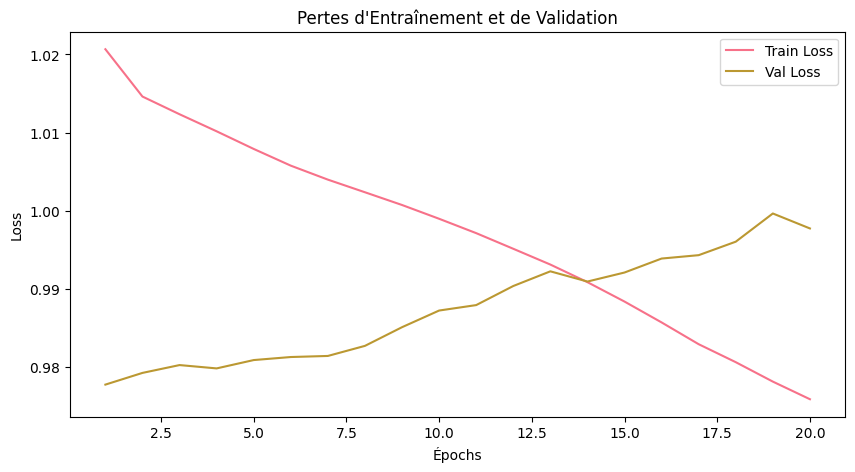

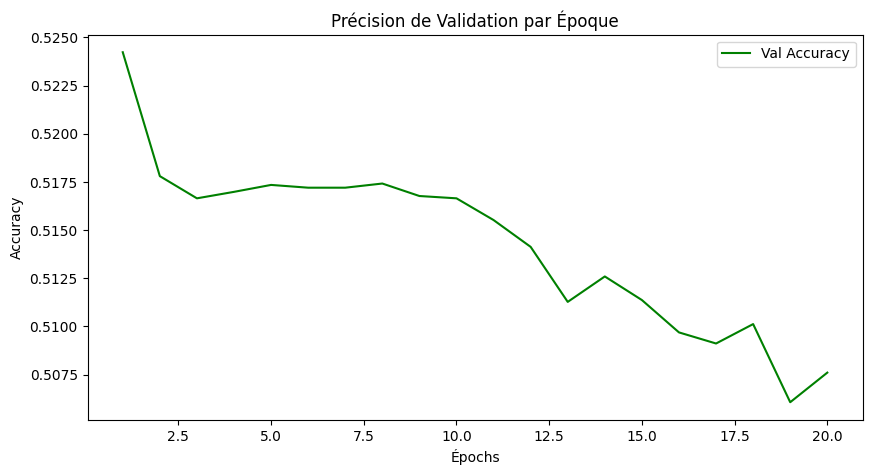

In [11]:
#Visualisation des pertes d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.title("Pertes d'Entraînement et de Validation")
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# (Optionnel) Visualisation de la précision de validation
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy', color='green')
plt.title('Précision de Validation par Époque')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
